<a href="https://colab.research.google.com/github/naenumtou/learnTensorFlow/blob/main/OCRResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Set auto reload
%reload_ext autoreload
%autoreload 2

In [2]:
# Change working directory
%cd /content/drive/My Drive/Colab Notebooks/ocr

/content/drive/My Drive/Colab Notebooks/ocr


In [3]:
# Import libraries
import pandas as pd
import gc
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# Neural network libraies
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator, \
                                                 load_img, \
                                                 img_to_array, \
                                                 array_to_img
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Checking GPU available
if tf.test.gpu_device_name() == '/device:GPU:0':
  print('GPU is available')
else:
  print('GPU is not available')

print(f'Tensorflow version: {tf.__version__}')

# Config display
%config InlineBackend.figure_format = 'retina'

GPU is available
Tensorflow version: 2.7.0


In [4]:
# Define load data function
def loadData():
  # MNIST Data
  (digitImageTrain, digitLabelTrain), (digitImageTest, digitLabelTest) = mnist.load_data()
  digitLabel = np.hstack((digitLabelTrain, digitLabelTest))
  digitImage = np.vstack((digitImageTrain, digitImageTest))

  #A-Z Data
  alphaData = pd.read_csv('A_Z Handwritten Data.csv')
  alphaLabel = np.array(alphaData['0']) #The '0' column is the target
  alphaLabel += 10 #A-Z will not overlab with MNIST
  alphaImage = alphaData.drop(['0'], axis = 1) #Drop target column
  alphaImage = np.reshape(
      alphaImage.values,
      (alphaImage.shape[0], 28, 28)
  ) #Resize to (28*28)

  # Combine datasets
  labels = np.hstack((digitLabel, alphaLabel))
  data = np.vstack((digitImage, alphaImage))
  return data, labels

In [5]:
# Load data
data, labels = loadData()
print(f'Data shape: {data.shape}')
print(f'Labels shape: {labels.shape}')

11501568/11490434 [==============================] - 0s 0us/step
Data shape: (442450, 28, 28)
Labels shape: (442450,)


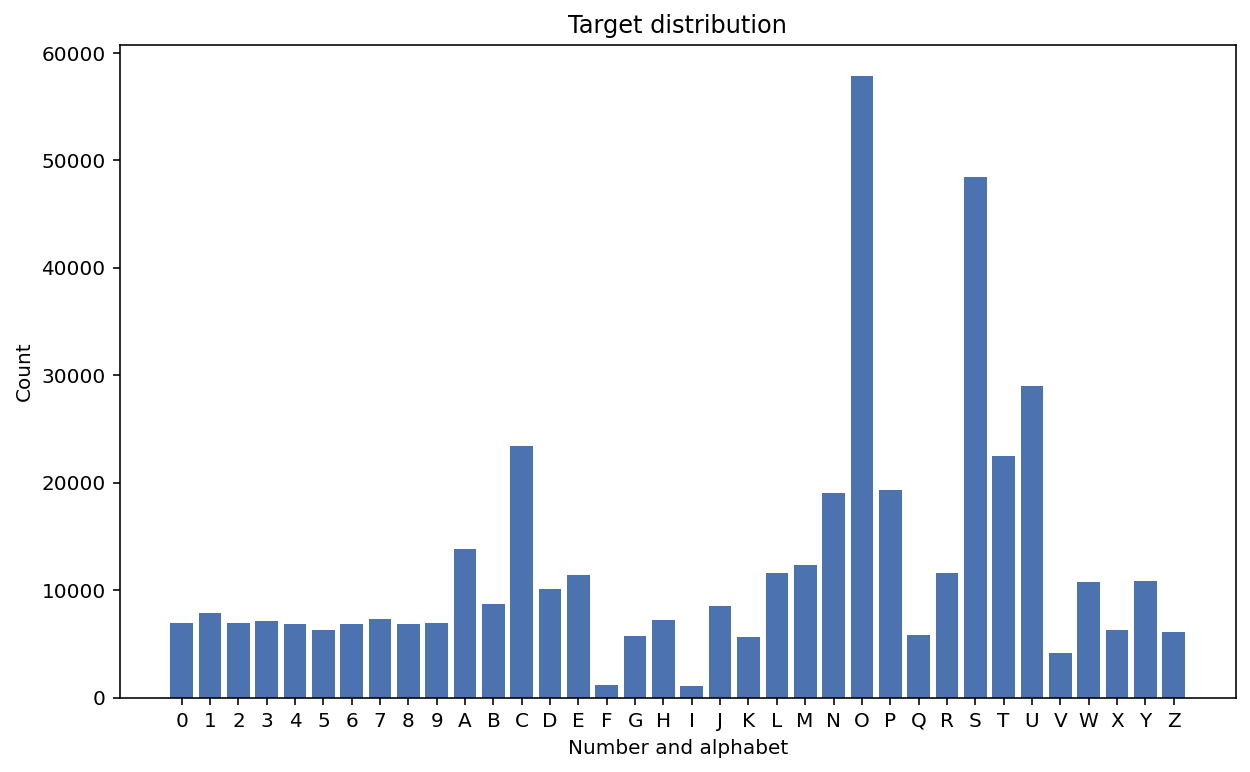

In [6]:
# Data preparation
# Target distribution
_, countLabels = np.unique(
    labels,
    return_counts = True
)

labelNames = list('0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')

# Plot
plt.figure(figsize = (10, 6))
with plt.style.context('seaborn-deep'):
  plt.bar(labelNames, countLabels)
  plt.title('Target distribution')
  plt.xlabel('Number and alphabet')
  plt.ylabel('Count')
plt.show()

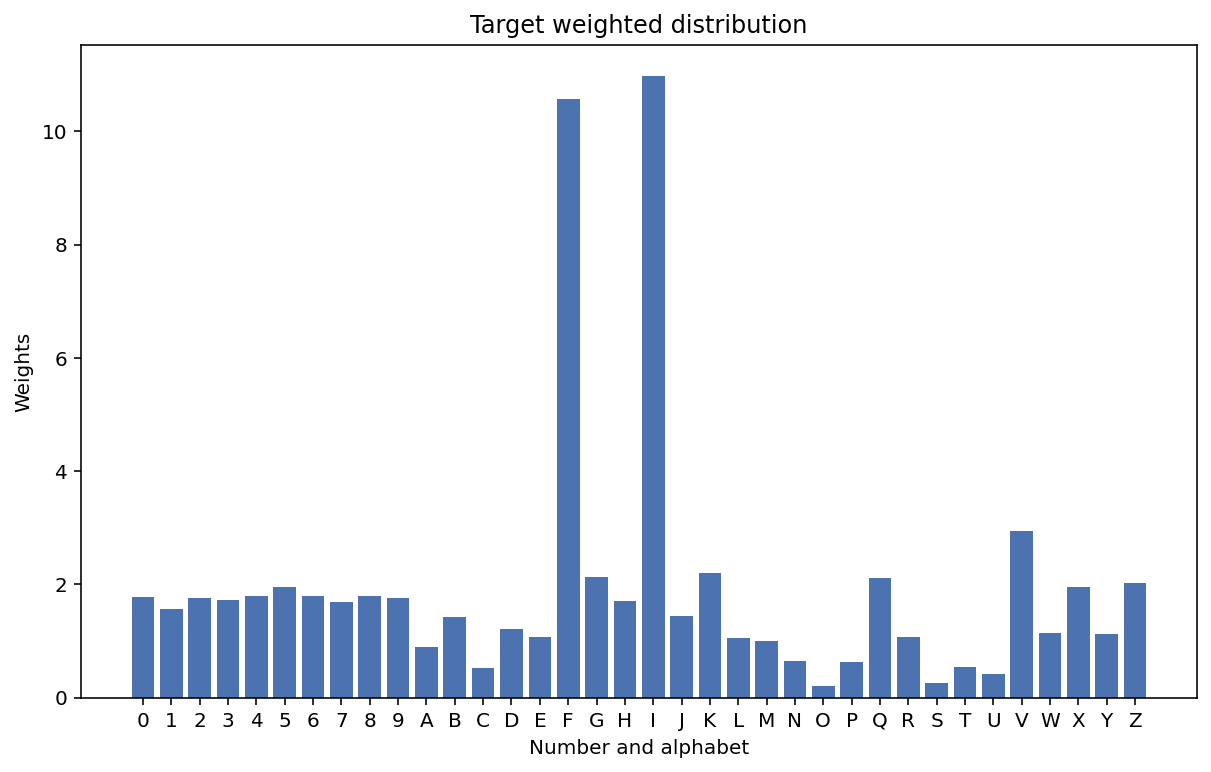

In [7]:
# Balance class weights for target
classValues = compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(labels),
    y = labels
)

# Create weights dictionary for neural network
classWeights = dict(
    zip(np.unique(labels), classValues)
)

# Plot 
plt.figure(figsize = (10, 6))
with plt.style.context('seaborn-deep'):
  plt.bar(labelNames, classValues)
  plt.title('Target weighted distribution')
  plt.xlabel('Number and alphabet')
  plt.ylabel('Weights')
plt.show()

In [8]:
# Labels encoding
encoder = LabelBinarizer()
labels = encoder.fit_transform(labels)

# Show array after encoded
print(f'First target encoded: {labels[0]}')

First target encoded: [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


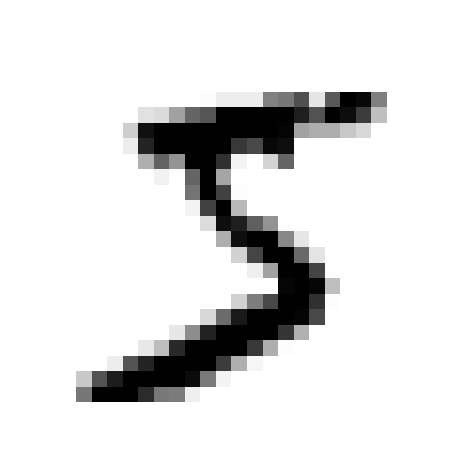

In [9]:
# Show first image (Must be 5)
plt.imshow(data[0], cmap = plt.cm.binary)
plt.axis('off')
plt.show()

In [10]:
# Images for transfer learning
# Convert to tensor array
data = np.array(data).reshape(-1, 28, 28, 1)
print(f'Data shape: {data.shape}')

Data shape: (442450, 28, 28, 1)


In [11]:
# Resize, convert to 3-channels and float32
# Define function for image processing
def imgProcessing(image):
  img = array_to_img(image, scale = False) #Return as PIL Image
  img = img.resize((32, 32)) #For ResNet50 Pre-trainned model
  img = img.convert(mode = 'RGB') #3-channels
  arr = img_to_array(img) #Back to array
  return arr.astype(np.float32) #To 'float32'

# Apply function for each image
data = [imgProcessing(img) for img in data]
data = np.array(data)
data /= 255.0 #Normalisation
print(f'Data shape: {data.shape}')

Data shape: (442450, 32, 32, 3)


In [12]:
# Train test splits
XTrain, XTest, yTrain, yTest = train_test_split(
    data,
    labels,
    test_size = 0.20,
    stratify = labels,
    random_state = 101
)

# Delete data
del data, labels

# Clear memory
gc.collect()

print(f'Training data shape: {XTrain.shape}')
print(f'Training label shape: {yTrain.shape}')
print(f'Validation data shape: {XTest.shape}')
print(f'Validation label shape: {yTest.shape}')

Training data shape: (353960, 32, 32, 3)
Training label shape: (353960, 36)
Validation data shape: (88490, 32, 32, 3)
Validation label shape: (88490, 36)


In [13]:
# Images augmentation
imgAug = ImageDataGenerator(
    zoom_range = 0.1,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    horizontal_flip = False
)

In [14]:
# Define model parameters
BS = 128
EPOCHS = 25
RATE = 0.001

# Transfer learning with ResNet50
baseModel = ResNet50(
    include_top = False, #Transfer learning
    weights = 'imagenet',
    input_shape = (32, 32, 3)
)

# Optimizer
opt = SGD(learning_rate = RATE)

# Total classes
nClasses = len(labelNames)

94781440/94765736 [==============================] - 1s 0us/step


In [15]:
# Create neural network
model = Sequential()
model.add(baseModel)
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(nClasses, activation = 'softmax')) #Output layer

# Compile model
model.compile(
    optimizer = opt,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [16]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 36)                4644      
                                                                 
Total params: 23,854,628
Trainable params: 23,801,508
Non-trainable params: 53,120
_________________________________________________________________


In [17]:
# Freezing layers prior the last convolutional ('conv5_block1_0_conv')
for layer in model.layers[0].layers:
  if layer.name == 'conv5_block1_0_conv':
    break
  layer.trainable = False

In [18]:
# Training model
history = model.fit(
    imgAug.flow(
        XTrain,
        yTrain,

    ),
    validation_data = (XTest, yTest),
    epochs = EPOCHS,
    steps_per_epoch = len(XTrain) // BS,
    class_weight = classWeights
)

Epoch 1/25
2765/2765 [==============================] - 353s 122ms/step - loss: 1.4463 - accuracy: 0.5748 - val_loss: 0.4477 - val_accuracy: 0.8462
Epoch 2/25
2765/2765 [==============================] - 352s 127ms/step - loss: 0.4825 - accuracy: 0.8122 - val_loss: 0.3282 - val_accuracy: 0.8754
Epoch 3/25
2765/2765 [==============================] - 351s 127ms/step - loss: 0.3627 - accuracy: 0.8497 - val_loss: 0.2605 - val_accuracy: 0.8941
Epoch 4/25
2765/2765 [==============================] - 353s 128ms/step - loss: 0.3043 - accuracy: 0.8668 - val_loss: 0.2648 - val_accuracy: 0.8897
Epoch 5/25
2765/2765 [==============================] - 353s 128ms/step - loss: 0.2625 - accuracy: 0.8817 - val_loss: 0.2489 - val_accuracy: 0.8993
Epoch 6/25
2765/2765 [==============================] - 335s 121ms/step - loss: 0.2477 - accuracy: 0.8872 - val_loss: 0.2568 - val_accuracy: 0.8911
Epoch 7/25
2765/2765 [==============================] - 352s 127ms/step - loss: 0.2293 - accuracy: 0.8935 - val_

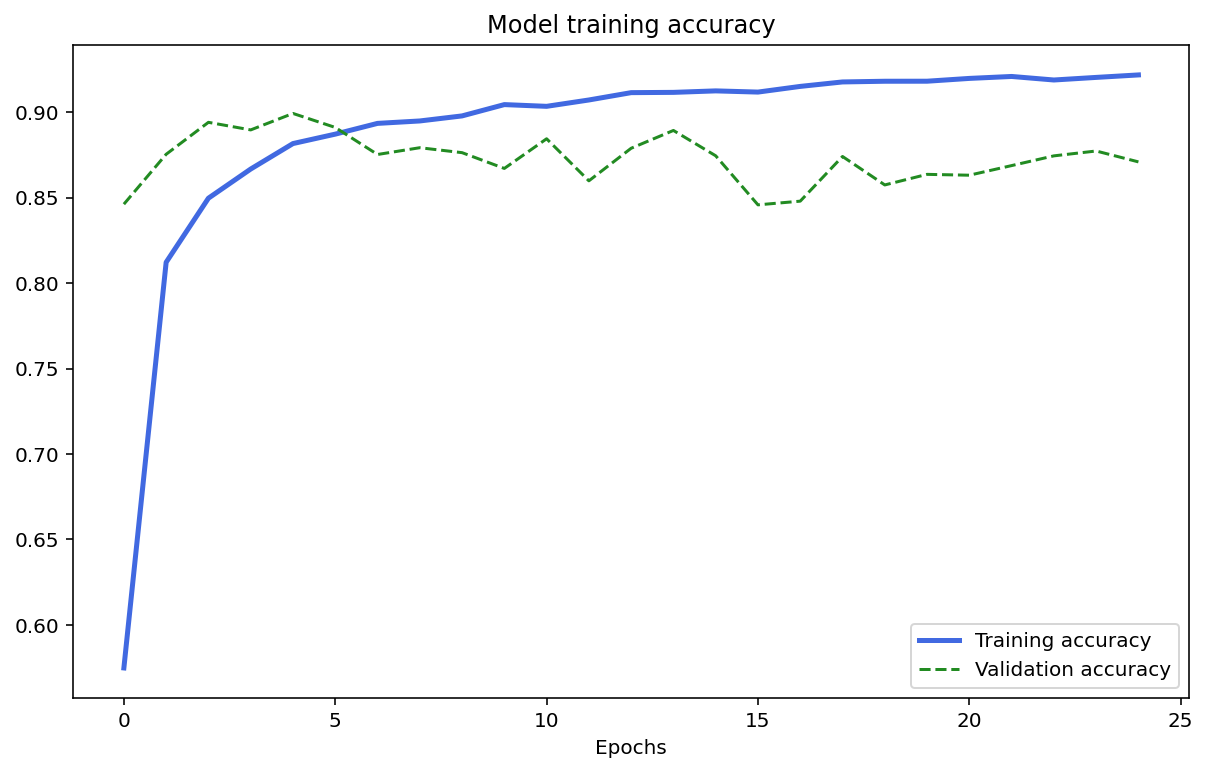

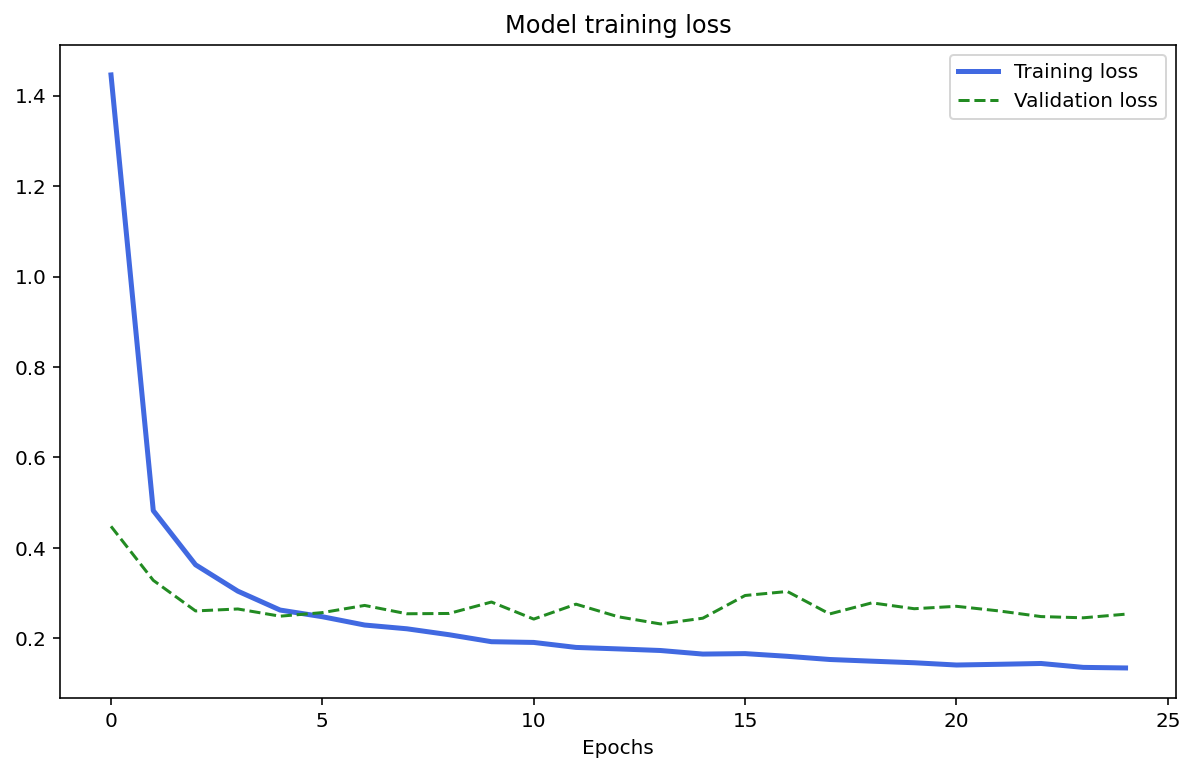

In [19]:
# Plot
plt.figure(figsize = (10, 6))
with plt.style.context('seaborn-deep'):
  plt.plot(
      history.history['accuracy'],
      c = 'royalblue',
      linewidth = 2.5,
      label = 'Training accuracy'
  )
  plt.plot(
      history.history['val_accuracy'],
      c = 'forestgreen',
      linestyle = '--',
      label = 'Validation accuracy'
  )
  plt.legend(frameon = True, facecolor = 'white')
  plt.title('Model training accuracy')
  plt.xlabel('Epochs')
plt.show()

plt.figure(figsize = (10, 6))
with plt.style.context('seaborn-deep'):
  plt.plot(
      history.history['loss'],
      c = 'royalblue',
      linewidth = 2.5,
      label = 'Training loss'
  )
  plt.plot(
      history.history['val_loss'],
      c = 'forestgreen',
      linestyle = '--',
      label = 'Validation loss'
  )
  plt.legend(frameon = True, facecolor = 'white')
  plt.title('Model training loss')
  plt.xlabel('Epochs')
plt.show()

In [20]:
# Prediction
pred = model.predict(
    XTest,
    batch_size = BS
).argmax(axis = 1) #Array of prediction results

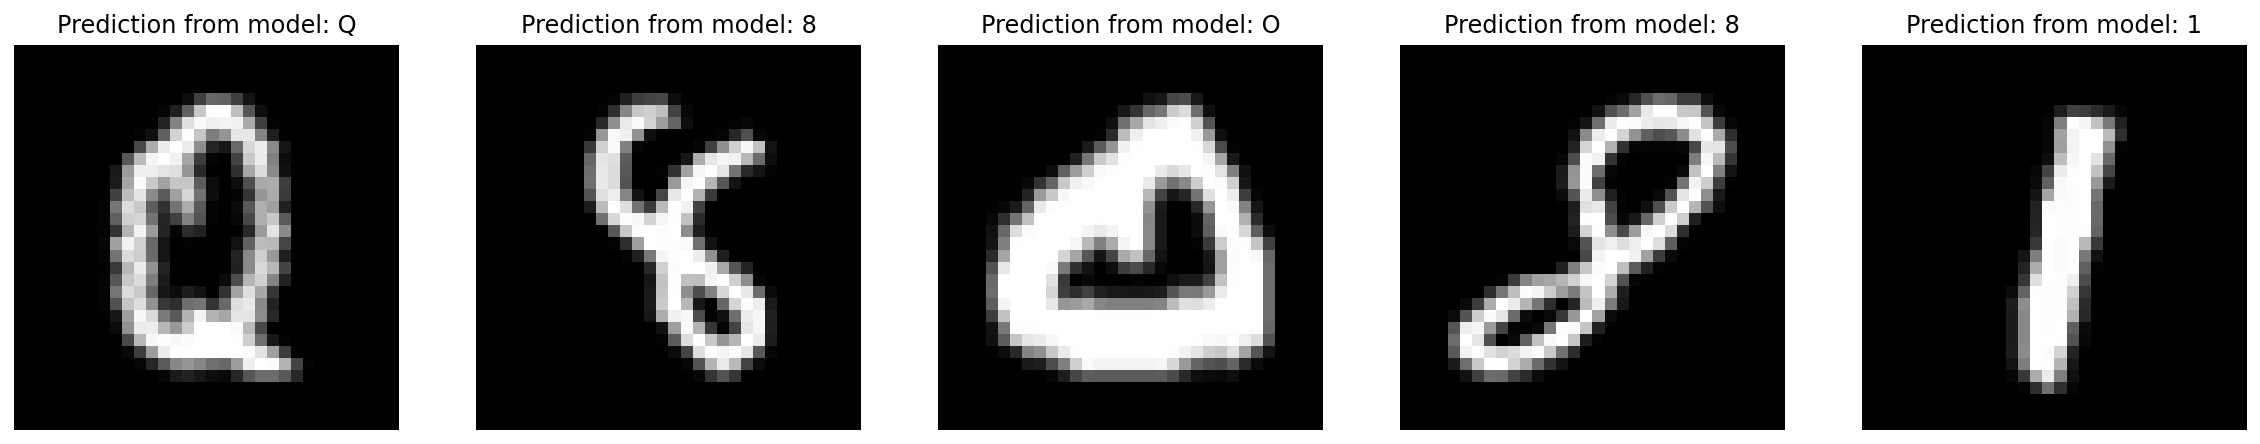

In [21]:
# Show prediction
random = np.random.choice(XTest.shape[0], 5)

plt.figure(figsize = (20, 4))
for j, i in enumerate(random):
  plt.subplot(1, 5, j + 1)
  imageShow = (XTest[i] * 255).astype('uint8')
  plt.imshow(imageShow, cmap = plt.cm.binary)
  plt.title(f'Prediction from model: {labelNames[pred[i]]}')
  plt.axis('off')  
plt.show()

In [ ]:
# Save model
model.save('ocrResNet.model')